In [1]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [53]:
scan_name ="knife_edge_X_005"


DIR = "/sf/alvra/data/p17982/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17982/res/scan_info/"

In [56]:
!ls -lah -rt $DIR | grep BSREAD.h5
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

-rw-r--r--.  1 root p17982  24M Oct 31 11:16 knife_edge_X_005_step0000.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:16 knife_edge_X_005_step0001.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:16 knife_edge_X_005_step0002.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0003.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0004.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0005.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0006.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0007.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0008.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0009.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:17 knife_edge_X_005_step0010.BSREAD.h5
-rw-r--r--.  1 root p17982  24M Oct 31 11:18 knife_edge_X_005_step0011.BSREAD.h5
-rw-r--r--.  1 root p17982  

In [65]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal = []
err_Signal = []

Izero = []
err_Izero = []

Position_mm = []


for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        (data_t_shot, data_f_shot, Izero_shot, laser_shot, position_shot, pulseIDs) = \
        load_FEL_scans_pulseID(filename, channel_position_X, 50)
        
        Signal.append(data_t_shot.mean())
        err_Signal.append(data_t_shot.std()/np.sqrt(data_t_shot.size))
        
        Izero.append(Izero_shot.mean())
        err_Izero.append(Izero_shot.std()/np.sqrt(Izero_shot.size))
    
        position_shot = [x for x in position_shot if (np.abs(x) > 0)]
        Position_mm.append(np.mean(position_shot))
        #Position_mm.append(position_loop[0])
    
Signal = np.asarray(Signal)
err_Signal = np.asarray(err_Signal)

Izero = np.asarray(Izero)
err_Izero = np.asarray(err_Izero)

Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17982/res/scan_info/knife_edge_X_005_scan_info.json
Processing 31 files
step 1 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0000.BSREAD.h5
step 2 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0001.BSREAD.h5
step 3 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0002.BSREAD.h5
step 4 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0003.BSREAD.h5
step 5 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0004.BSREAD.h5
step 6 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0005.BSREAD.h5
step 7 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0006.BSREAD.h5
step 8 of 31 : Processing /sf/alvra/data/p17982/raw/scan_data/knife_edge_X_005/knife_edge_X_005_step0007.BS

In [66]:
#Normalization

Signal_norm = Signal #/ Izero
err_Signal_norm = err_Signal #/ Izero

<IPython.core.display.Javascript object>


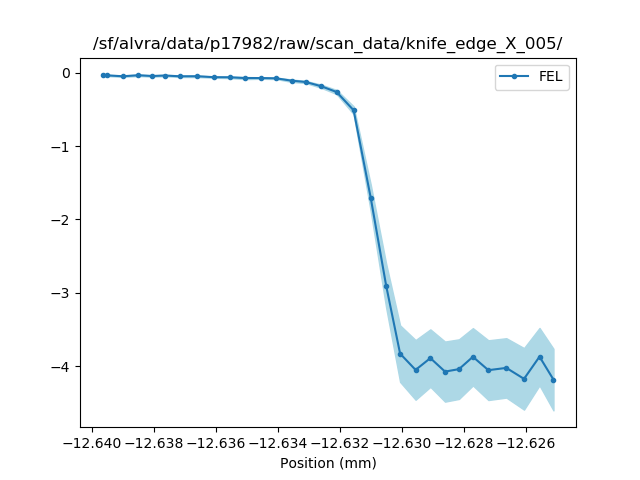

In [67]:
plt.figure()

plt.plot(Position_mm, Signal_norm, label="FEL",marker='.')
low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm


plt.fill_between(Position_mm, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")


plt.show()
#plt.savefig('Timescan_7_diode')

In [69]:
# Now fit with error function (defined above)
parameters,extras = curve_fit(errfunc_fwhm, Position_mm, Signal_norm, p0 = [0.1, 1.6, -12.63, 0.1]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = -12.631 mm
Width = 0.001 mm


<IPython.core.display.Javascript object>


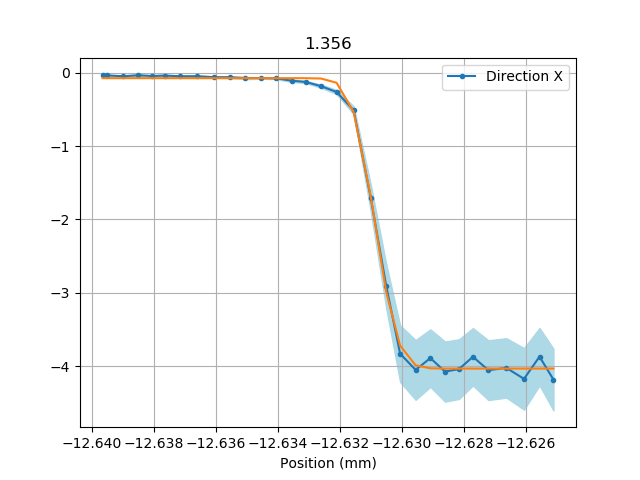

In [71]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Position_mm, Signal_norm, label="Direction X",marker='.')
plt.plot(Position_mm, errfunc_fwhm(Position_mm,*parameters))

low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm

plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

plt.title(np.round(np.abs(parameters[3])*1000, 4) )
#plt.title("X direction")
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')